# W207 Final Project - Facial Keypoint Recognition 
#### Alex Carite | Oscar Linares | Greg Rosen | Shehzad Shahbuddin

In [3]:
# dependencies
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

import time
import os.path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
from random import randrange
%matplotlib inline

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)

OK
Tensorflow version 2.8.0


### Load Data 

In [4]:
#Checking to see if the train/test csv are loaded, if not, unzip from dir
if (os.path.exists('training.csv') == False):
    !unzip training.zip
else:
    print('training data already unzipped')

if (os.path.exists('test.csv') == False):
    !unzip test.zip
else:
    print('test data already unzipped')

training data already unzipped
test data already unzipped


In [5]:
# load data
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(7049, 31)
(1783, 2)


# Need to clean up a few NA's in our set


In [6]:
# helper functions for data shapes
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


In [7]:
# transform all data
X = np.array([two_dim(train.Image[i]) for i in range(len(train))])
# X_tmp = X_tmp / 255.0
# X = np.array([make_array(train.Image[i]) for i in range(len(train))])
X = X / 255.0
Y = np.array([train.drop('Image', axis = 1).iloc[i] for i in range(len(train))])

#Need to make X_test and Y_test (will we have a Y_test? I think that may be handled in Kaggle)

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
train_data, train_labels = X[:5000], Y[:5000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
dev_data, dev_labels = X[5000:], Y[5000:]
numFeatures = train_data[1].size
numTrainExamples = train_data.shape[0]
numMiniExamples = mini_train_data.shape[0]
numDevExamples = dev_data.shape[0]
# numTestExamples = test_data.shape[0]
print(f'Train examples {numTrainExamples}')
print(f'Train features {numFeatures}')
print(f'mini_Train examples {numMiniExamples}')
print(f'Dev examples {numDevExamples}')
# print(f'Test examples {numTestExamples}')

Train examples 5000
Train features 9216
mini_Train examples 1000
Dev examples 2049


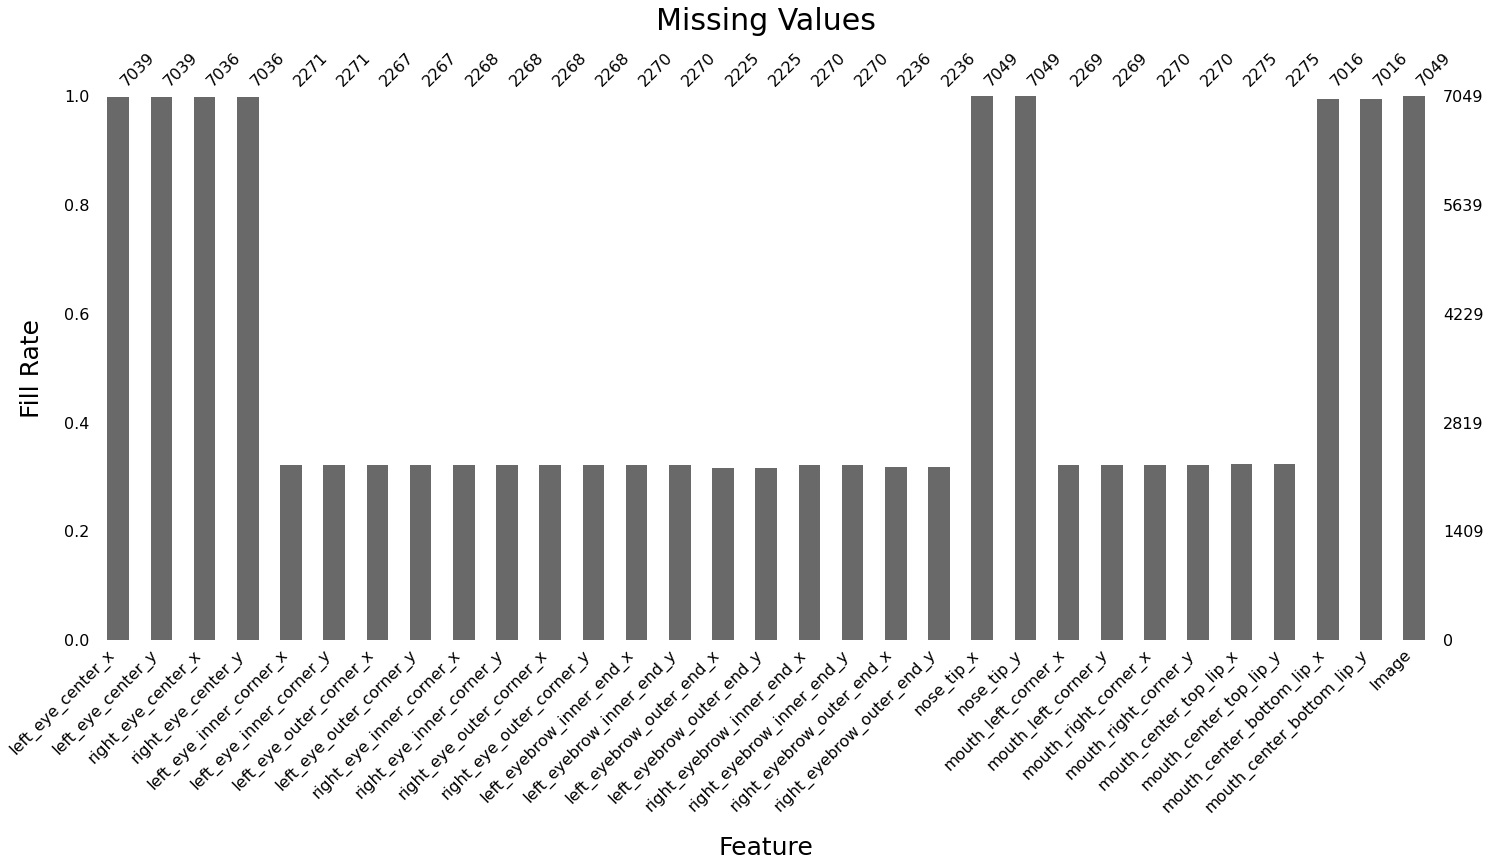

In [8]:
# view missing values
import missingno as msno
fig, ax = plt.subplots()
msno.bar(train)
ax.set_title("Missing Values", fontsize = 30, pad = 20)
ax.set_xlabel("Feature", fontsize = 25, labelpad = 20)
ax.set_ylabel("Fill Rate", fontsize = 25, labelpad = 20)
plt.show()

In [9]:
# EDA see how many na's for each column in the training dataset
train.isna().sum()/len(train)*100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

## EDA (Removing Missing Values)
We lose 70% of the dataset when removing NAs

In [13]:
#Checking for duplicates 
train.duplicated(subset = ['Image'])

0       False
1       False
2       False
3       False
4       False
        ...  
7044     True
7045     True
7046    False
7047    False
7048     True
Length: 7049, dtype: bool

In [ ]:
#Drop all NAs to have a clean fully labeled dataset
train_noNA = train.dropna(axis=0, how='any', inplace = False)
train_noNA = train_noNA.reset_index(drop=True)
print(len(train))
print(len(train_noNA))

In [ ]:
train_unlab = train[train.isnull().any(1)]
train_unlab = train_unlab.reset_index(drop = True)
print(len(train))
print(len(train_unlab))

Create arrays for no-NA dataset.

In [ ]:
# transform No NaN data
X_noNA = np.array([two_dim(train_noNA.Image[i]) for i in range(len(train_noNA))])
X_noNA = X_noNA / 255.0
Y_noNA = np.array([train_noNA.drop('Image', axis = 1).iloc[i] for i in range(len(train_noNA))])


shuffle_noNA = np.random.permutation(np.arange(X_noNA.shape[0]))
X_noNA, Y_noNA = X_noNA[shuffle_noNA], Y_noNA[shuffle_noNA]
train_data_noNA, train_labels_noNA = X_noNA[:1200], Y_noNA[:1200]
dev_data_noNA, dev_labels_noNA = X_noNA[1200:], Y_noNA[1200:]
numFeatures_noNA = train_data_noNA[1].size
numTrainExamples_noNA = train_data_noNA.shape[0]
numDevExamples_noNA = dev_data_noNA.shape[0]
# numTestExamples = test_data.shape[0]
print(f'Train examples {numTrainExamples_noNA}')
print(f'Train features {numFeatures_noNA}')
print(f'Dev examples {numDevExamples_noNA}')
# print(f'Test examples {numTestExamples_noNA}')

In [ ]:
# transform unlabeled data
X_unlab = np.array([two_dim(train_unlab.Image[i]) for i in range(len(train_unlab))])
X_unlab = X_unlab / 255.0
Y_unlab = np.array([train_unlab.drop('Image', axis = 1).iloc[i] for i in range(len(train_unlab))])


shuffle_unlab = np.random.permutation(np.arange(X_unlab.shape[0]))
X_unlab, Y_unlab = X_unlab[shuffle_unlab], Y_unlab[shuffle_unlab]
train_data_unlab, train_labels_unlab = X_unlab[:3000], Y_unlab[:3000]
dev_data_unlab, dev_labels_unlab = X_unlab[3000:], Y_unlab[3000:]
numFeatures_unlab = train_data_unlab[1].size
numTrainExamples_unlab = train_data_unlab.shape[0]
numDevExamples_unlab = dev_data_unlab.shape[0]
# numTestExamples = test_data.shape[0]
print(f'Train examples {numTrainExamples_unlab}')
print(f'Train features {numFeatures_unlab}')
print(f'Dev examples {numDevExamples_unlab}')
# print(f'Test examples {numTestExamples_unlab}')

In [ ]:
def plot_image(X, y, n, plot_missing = False):
    """
    plot n images with red dots for labels.
    If plot_missing, plot images with missing values (useful for visualizing imputed labels)"""
    if not plot_missing:
        for i in range(n):
            plt.imshow(X[i],cmap='gray')
            #place a point for each of the pictures on the specified coordinates
            for loc in range(0, len(y[i]),2):
                plt.plot(y[i][loc], y[i][loc+1], '*r')
            plt.show()
        
    elif plot_missing:
        for i in train[train['left_eye_outer_corner_y'].isna()].index[:n]:
            plt.imshow(X[i],cmap='gray')
            #place a point for each of the pictures on the specified coordinates
            for loc in range(0, len(y[i]),2):
                plt.plot(y[i][loc], y[i][loc+1], '*r')
            plt.show()


In [ ]:
#Create function for showing images
def show_images(data, labels, num_examples=3):
  
  #transform data  into 2D matrix
  X2D = np.reshape(data, (-1, 96, 96))

  num = num_examples * 3
  count = 0

  #create a figure 
  fig, axes = plt.subplots(num_examples, 3, figsize = (9.6, 9.6))


  #iterate across the row of images and display one image in each of the num_examples boxes
  for n in range(num):
      ax = axes[count//num_examples, count%num_examples]
      rand = randrange(0, len(data))
      ax.imshow(X2D[rand], cmap = 'gray')
      count += 1
      for loc in range(0, len(labels[n]), 2):
          ax.plot(labels[n][loc], labels[n][loc+1], '*r')
      
  plt.tight_layout()
  plt.show()


View some images with labeled points.

In [ ]:
#explore some of the images in the training data
show_images(train_data, train_labels)

View images without missing values.

In [ ]:
#Same analysis as above but with the noNA dataset - notice the how all the features are marked on the face
show_images(train_data_noNA, train_labels_noNA)

Note that images with missing values are not as accurate as fully filled records, even for the values it has filled.

In [ ]:
#continue EDA, see distribution of all coordinates in train data except the "Image" column
train.hist(bins = 30, figsize=(15,15))
plt.show()

In [ ]:
#take a look at removing outliers
# train_outliers  = train[((train['left_eye_inner_corner_x'] - train['left_eye_inner_corner_x'].mean()) / train['left_eye_inner_corner_x'].std()).abs() < 3]
train_outliers = train[train.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
train_outliers.hist(bins = 30, figsize=(15,15))
plt.show()

In [ ]:
#create df for noNA data to do the same analysis as above
tempdf = pd.DataFrame(train_labels_noNA)
tempdf.hist(bins = 30, figsize=(15,15))
plt.show()

Use the next two cells if you want to explore the dev data to make sure it's clean as well

In [ ]:
#tempdf = pd.DataFrame(dev_labels_noNA)

In [ ]:
#tempdf.hist(bins = 30, figsize=(15,15))

In [ ]:
#Confirm size of the datasets
print(train_data_noNA.shape)
print(train_labels_noNA.shape)
print(dev_data_noNA.shape)
print(dev_labels_noNA.shape)

### Exploratory Data Analysis (Keeping Missing Values)

### Forward Fill Missing Value Imputation

In [ ]:
# impute missing values
train_ffill = train.fillna(method = "ffill")

# transform Y for ffill in same way as non-ffill data (create for ffill imputation visuals)
Y_ffill = np.array([train_ffill.drop('Image', axis = 1).iloc[i] for i in range(len(train_ffill))])
Y_ffill = Y_ffill[shuffle]

# transform train and dev labels for model
train_labels_ffill = Y_ffill[:5000]
dev_labels_ffill = Y_ffill[5000:]

### KNN Missing Value Imputation

In [ ]:
# scale data (optimal for KNN distances)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.drop(columns = "Image"))
train_labels_scaled = scaler.fit_transform(train_labels)
# mini_train_labels_scaled = scaler.fit_transform(mini_train_labels)
dev_labels_scaled = scaler.fit_transform(dev_labels)

# KNN Imputation (scaled) (K = 5)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
train_knn_scaled = imputer.fit_transform(train_scaled)
train_labels_knn_scaled = imputer.fit_transform(train_labels_scaled)
# mini_train_labels_knn_scaled = imputer.fit_transform(mini_train_labels_scaled)
dev_labels_knn_scaled = imputer.fit_transform(dev_labels_scaled)

### removing in lieu of scaled KNN
# # KNN Imputation (no scale) (K = 5)
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# train_knn = imputer.fit_transform(train.drop(columns="Image"))
# train_labels_knn = imputer.fit_transform(train_labels)
# # mini_train_labels_knn = imputer.fit_transform(mini_train_labels)
# dev_labels_knn = imputer.fit_transform(dev_labels)

# Inverse transform after imputation for viewing performance on images
train_knn_scaled_inverse = scaler.inverse_transform(train_knn_scaled)
train_labels_knn_scaled_inverse = scaler.inverse_transform(train_labels_knn_scaled)
# mini_train_labels_knn_scaled_inverse = scaler.inverse_transform(mini_train_labels_knn_scaled)
dev_labels_knn_scaled_inverse = scaler.inverse_transform(dev_labels_knn_scaled)

In [ ]:
# confirm no more missing values (knn)
import missingno as msno
fig, ax = plt.subplots()
msno.bar(pd.DataFrame(train_knn_scaled_inverse, columns = train.drop(columns = "Image").columns))
ax.set_title("Missing Values after KNN", fontsize = 30, pad = 20)
ax.set_xlabel("Feature", fontsize = 25, labelpad = 20)
ax.set_ylabel("Fill Rate", fontsize = 25, labelpad = 20)
plt.show()

#### View Images of Each Imputation

In [ ]:
# check original images (for comparison)
show_images(train_data, train_labels)

In [ ]:
# check KNN-plotted images
show_images(train_data, train_labels_knn_scaled_inverse)

In [ ]:
# check ffill-plotted images
show_images(train_data, Y_ffill)

# Modeling on the data

In [ ]:
# shape tuples for reshaping the data for model
train_reshape = (5000, 9216)
train_noNA_reshape = (1200, 9216)
dev_reshape = (2049, 9216)
dev_noNA_reshape = (940, 9216)
label_reshape= (-1, 30)

### Baseline

In [ ]:
# baseline model with NAs
model_base = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model_base.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_base.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model_base.fit(train_data.reshape(train_reshape), train_labels, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score_base = model_base.evaluate(dev_data.reshape(dev_reshape), dev_labels, verbose=0) 
print('Test score:', score_base[0]) 
print('Test accuracy:', score_base[1])

With so many NAs in the data, the model is not able to perform.

### ffill-imputed

Modeling on the ffill-imputed dataset.

In [ ]:
# ffill-imputed model
model_NN_ff1 = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model_NN_ff1.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_NN_ff1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model_NN_ff1.fit(train_data.reshape(train_reshape), train_labels_ffill, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score_NN_ff1 = model_NN_ff1.evaluate(dev_data.reshape(dev_reshape), dev_labels_ffill, verbose=0)
print('Test score:', score_NN_ff1[0]) 
print('Test accuracy:', score_NN_ff1[1])

### KNN-imputed

Modeling on the knn-imputed dataset.

In [ ]:
# KNN-imputed model
model_NN_knn1 = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model_NN_knn1.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_NN_knn1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model_NN_knn1.fit(train_data.reshape(train_reshape), train_labels_knn_scaled_inverse, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score_NN_knn1 = model_NN_knn1.evaluate(dev_data.reshape(dev_reshape), dev_labels_knn_scaled_inverse, verbose=0)
print('Test score:', score_NN_knn1[0]) 
print('Test accuracy:', score_NN_knn1[1])

Now we will do the same model but on the cleaned noNA datasets.

### Missing Value Records Removed

In [ ]:
# No NA model
model_NN_noNA1 = Sequential()
# model_NN_noNA1.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model_NN_noNA1.add(Dense(30, input_dim=30, activation='sigmoid'))
model_NN_noNA1.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_NN_noNA1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model_NN_noNA1.fit(train_data_noNA.reshape(train_noNA_reshape), train_labels_noNA, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score_NN_noNA1 = model_NN_noNA1.evaluate(dev_data_noNA.reshape(dev_noNA_reshape), dev_labels_noNA, verbose=0) 
print('Test score:', score_NN_noNA1[0]) 
print('Test accuracy:', score_NN_noNA1[1])

In [ ]:
model_NN_noNA1.summary()

Because baseline performance is higher on the missing-value-removed model, and the filled values on the missing-value records are inaccurate, we will proceed with iterating on the no-na model (or maybe we will add an additional label that specifies which records had imputed values) so the model can take that into consideration.

### Lets try and see if Label prop (Semi-suprivised) can beat the above accuracy 

In [ ]:
train_labels_mix = np.nan_to_num(train_labels, nan = -1) 
df = pd.DataFrame(train_labels_mix)
df = df.round(2).astype(int)

df_dev = pd.DataFrame(dev_labels_noNA)
df_dev = df_dev.round(2).astype(int)

feature_names = list(train.columns)[:30]

df_1 = pd.DataFrame()

for i in range(30):
    model = LabelPropagation()
    model.fit(train_data.reshape(train_reshape), df[i])
    
    new_labels = model.transduction_

    df_1[feature_names[i]] = new_labels

df_1



In [ ]:
lp_train_labels = df_1.to_numpy()
lp_train_labels.shape



In [ ]:

model_NN_lp = Sequential()
# model_NN_lp.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model_NN_lp.add(Dense(30, input_dim=30, activation='sigmoid'))
model_NN_lp.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_NN_lp.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model_NN_lp.fit(train_data.reshape(train_reshape), lp_train_labels, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score_NN_lp = model_NN_lp.evaluate(dev_data_noNA.reshape(dev_noNA_reshape), dev_labels_noNA, verbose=0) 
print('Test score:', score_NN_lp[0]) 
print('Test accuracy:', score_NN_lp[1])

In [ ]:
show_images(train_data, lp_train_labels)

In [ ]:
df_2 = pd.DataFrame()

for i in range(30):
    model = LabelSpreading()
    model.fit(train_data.reshape(train_reshape), df[i])
    
    new_labels = model.transduction_

    df_2[feature_names[i]] = new_labels

df_2

ls_train_labels = df_2.to_numpy()
ls_train_labels.shape


In [ ]:
model_NN_ls = Sequential()
# model_NN_ls.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model_NN_ls.add(Dense(30, input_dim=30, activation='sigmoid'))
model_NN_ls.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_NN_ls.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model_NN_ls.fit(train_data.reshape(train_reshape), ls_train_labels, shuffle=True, batch_size=5, verbose=0, epochs=3) 
print ('Train time = %.2f' %(time.time() - start_time))
score_NN_ls = model_NN_ls.evaluate(dev_data_noNA.reshape(dev_noNA_reshape), dev_labels_noNA, verbose=0) 
print('Test score:', score_NN_ls[0]) 
print('Test accuracy:', score_NN_ls[1])

### Adding more layers (Missing Values Removed)

In [ ]:
model_NN_noNA2 = Sequential()
model_NN_noNA2.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model_NN_noNA2.add(Dense(30, input_dim=30, activation='softmax'))
model_NN_noNA2.add(Dropout(0.5))
model_NN_noNA2.add(Dense(units=30, input_dim=30, activation='softmax'))

sgd = optimizers.SGD(lr=0.0001)
model_NN_noNA2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model_NN_noNA2.fit(train_data_noNA.reshape(train_noNA_reshape), train_labels_noNA, shuffle=False, batch_size=10, verbose=0, epochs=50) 
print ('Train time = %.2f' %(time.time() - start_time))
score_NN_noNA2 = model_NN_noNA2.evaluate(dev_data_noNA.reshape(dev_noNA_reshape), dev_labels_noNA, verbose=0) 
print('Test score:', score_NN_noNA2[0]) 
print('Test accuracy:', score_NN_noNA2[1])

No additional gain on original model.

In [ ]:
model_NN_noNA2.summary() 

### Convolutional Model Baseline Attempt (Missing Values Removed)

In [ ]:
#reshape data into 2D arrays
x_train_96x96 = train_data_noNA.reshape(train_noNA_reshape).reshape(train_data_noNA.shape[0], 96, 96, 1)
x_dev_96x96 = dev_data_noNA.reshape(dev_noNA_reshape).reshape(dev_data_noNA.shape[0], 96, 96, 1)

model_CNN_noNA1 = Sequential() 
model_CNN_noNA1.add(Conv2D(96, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model_CNN_noNA1.add(Conv2D(192, (3, 3), activation='sigmoid'))
model_CNN_noNA1.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN_noNA1.add(Dropout(0.5))
model_CNN_noNA1.add(Flatten())
model_CNN_noNA1.add(Dense(units=50, input_dim=384, activation='sigmoid')) 
model_CNN_noNA1.add(Dense(units=30, input_dim=50, activation='softmax')) 

## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model_CNN_noNA1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model_CNN_noNA1.fit(x_train_96x96, train_labels_noNA, batch_size=100, epochs=5, verbose=1, validation_data=(x_dev_96x96, dev_labels_noNA))
score_CNN_noNA1 = model_CNN_noNA1.evaluate(x_dev_96x96, dev_labels_noNA, verbose=0)
print('Test score:', score_CNN_noNA1[0]) 
print('Test accuracy:', score_CNN_noNA1[1])

Again, no improvement in the test accuracy with CNN. No changes with batch size, epochs, or learning rate.

In [ ]:
model_CNN_noNA1.summary()